<p>
    <img src="https://s3.amazonaws.com/iotanalytics-templates/Logo.png" style="float:left;width:65px">
    <h1 style="float:left;color:#1A5276;padding-left:15px;font-size:20px;">AWS IoT Analytics | Notebook</h1>
</p>


When loading data from IoT Analytics datasets, the client should be initialized first:

In [1]:
import sys
import boto3
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
from matplotlib.dates import DateFormatter
from pandas.plotting import register_matplotlib_converters

In [2]:
# create IoT Analytics client
client = boto3.client('iotanalytics')

Now we can get the data location (URL) for the given dataset and start working with the data (In order to need to perform get_dataset_content, you need to grant iot analytics corresponding IAM permission):

In [3]:
# constants
MY_TIMEZONE='US/Eastern' # update to your local timezone or use 'UTC'
DATETIME_FORMAT='%y-%m-%d %H:%M' # update to your local date/time format

In [4]:
def date_parse(x):
    x = pd.to_datetime(x, infer_datetime_format=True, unit='s', utc=True)
    x = x.tz_convert(MY_TIMEZONE)
    return x

In [5]:
nrows_read = None # specify 'None' if want to read whole data set (10k records)

dataset = "iot_analytics_data_set"
dataset_url = client.get_dataset_content(datasetName = dataset)['entries'][0]['dataURI']

df = pd.read_csv(dataset_url,
                 nrows=nrows_read,
                 header=0,
                 low_memory=False,
                 infer_datetime_format=True,
                 date_parser=date_parse,
                 index_col=['ts'])

In [6]:
# clean up the DataFrame
df = df.drop(columns='__dt')
df = df.sort_values(by='ts', ascending=True)

In [7]:
# transform metadata attribute, from device registry, to valid json object
df['metadata'].replace('{','{"',regex=True, inplace = True)
df['metadata'].replace('=','":"',regex=True, inplace = True)
df['metadata'].replace(', ','","',regex=True, inplace = True)
df['metadata'].replace(':"{"',':{"',regex=True, inplace = True)
df['metadata'].replace('}",','},',regex=True, inplace = True)
df['metadata'].replace('}','"}',regex=True, inplace = True)

In [8]:
# example of extracting value from metadata attribute
metadata = pd.read_json(df['metadata'][0], orient='records', typ='series')
print(metadata['thingname'])

lora-iot-gateway-01


In [9]:
df.tail(5)

,device_id,gateway_id,temperature,humidity,pressure,red,green,blue,ambient,device,msg_received,metadata
ts,,,,,,,,,,,,
2020-08-24 13:29:59.578332663-04:00,0447383033363932003C0034,00000000f62051ce,72.45,45.02,99.55,14,48,54,67,lora-iot-gateway-01,2020-08-24T17:29:59.609+0000,"{""defaultclientid"":""lora-iot-gateway-01"",""thin..."
2020-08-24 13:30:09.644567966-04:00,0447383033363932003C0034,00000000f62051ce,72.50,45.08,99.55,14,47,54,66,lora-iot-gateway-01,2020-08-24T17:30:09.731+0000,"{""defaultclientid"":""lora-iot-gateway-01"",""thin..."
2020-08-24 13:30:14.680146933-04:00,0447383033363932003C0034,00000000f62051ce,72.46,45.01,99.56,13,47,54,66,lora-iot-gateway-01,2020-08-24T17:30:14.712+0000,"{""defaultclientid"":""lora-iot-gateway-01"",""thin..."
2020-08-24 13:30:19.722820997-04:00,0447383033363932003C0034,00000000f62051ce,72.54,45.10,99.55,13,46,53,65,lora-iot-gateway-01,2020-08-24T17:30:19.774+0000,"{""defaultclientid"":""lora-iot-gateway-01"",""thin..."
2020-08-24 13:30:24.757022619-04:00,0447383033363932003C0034,00000000f62051ce,72.57,45.00,99.56,13,45,53,64,lora-iot-gateway-01,2020-08-24T17:30:24.785+0000,"{""defaultclientid"":""lora-iot-gateway-01"",""thin..."


In [10]:
# initial readings were not reflective of environment
df = df.loc[df['msg_received'] >='2020-08-24T15:02:06.354+0000']

In [11]:
# filter temp/humidity outliers (>1% & <99%)
df = df.loc[df['temperature'] > df.groupby('device_id').temperature.transform(lambda x: x.quantile(.01))]
df = df.loc[df['temperature'] < df.groupby('device_id').temperature.transform(lambda x: x.quantile(.99))]

df = df.loc[df['humidity'] > df.groupby('device_id').humidity.transform(lambda x: x.quantile(.01))]
df = df.loc[df['humidity'] < df.groupby('device_id').humidity.transform(lambda x: x.quantile(.99))]

In [12]:
print('DataFrame Stats')
print('-------------')
print('Record count: {:,}'.format(df['temperature'].count()))
print('DataFrame size (MB): {:,.2f}'.format(sys.getsizeof(df)/1024/1024))
print('-------------')
print('Time range (min): {:%Y-%m-%d %H:%M:%S %Z}'.format(df.index[1]))
print('Time range (max): {:%Y-%m-%d %H:%M:%S %Z}'.format(df.index[-1]))
print('Temperature (min): {:.2f}{}'.format(df['temperature'].min(), '°F'))
print('Temperature (max): {:.2f}{}'.format(df['temperature'].max(), '°F'))
print('Humidity (min): {:.2f}{}'.format(df['humidity'].min(), '%'))
print('Humidity (max): {:.2f}{}'.format(df['humidity'].max(), '%'))
print('Barometric Pressure (min): {:.2f}{}'.format(df['pressure'].min(), ' kPa'))
print('Barometric Pressure (max): {:.2f}{}'.format(df['pressure'].max(), ' kPa'))

DataFrame Stats
-------------
Record count: 999
DataFrame size (MB): 0.77
-------------
Time range (min): 2020-08-24 11:02:16 EDT
Time range (max): 2020-08-24 13:30:24 EDT
Temperature (min): 70.07°F
Temperature (max): 73.06°F
Humidity (min): 42.63%
Humidity (max): 47.23%
Barometric Pressure (min): 99.55 kPa
Barometric Pressure (max): 99.71 kPa


In [13]:
# matplotlib datetime config
plt.rcParams['timezone']=MY_TIMEZONE
register_matplotlib_converters()
myFmt = DateFormatter(DATETIME_FORMAT)

## Scatter Plot using Matplotlib
Using Matplotlib: Visualization with Python

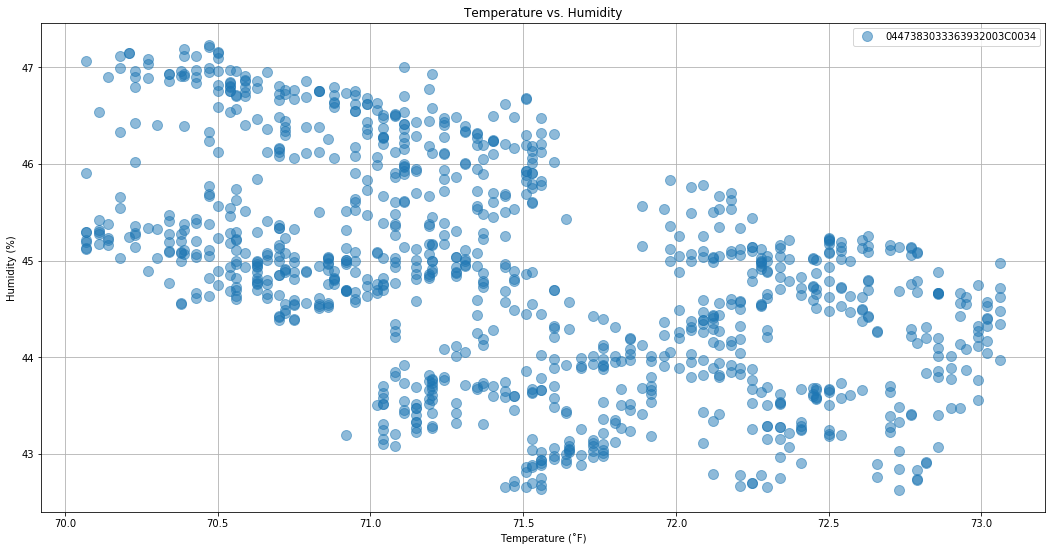

In [14]:
_, ax = plt.subplots(1, 1, figsize=(18, 9))
ax.plot(df.temperature,
        df.humidity,
        marker='o',
        linestyle='',
        alpha=.5,
        ms=10,
        label='0447383033363932003C0034')
ax.grid()
ax.margins(0.05)
ax.legend()
plt.title('Temperature vs. Humidity')
plt.xlabel('Temperature (˚F)')
plt.ylabel('Humidity (%)')
plt.show()

# Temperature Graph using Moving Average
Smoothing data using the mean average of a 1 minute rolling window.  
1 minutes == (12) data-points @ 5 second intervals

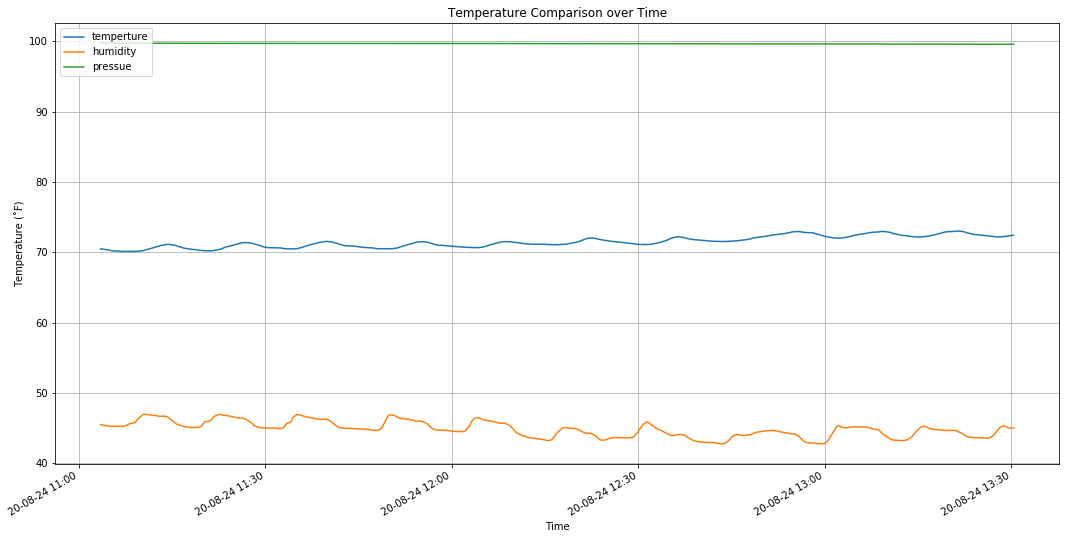

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(18, 9))
mean_temp = df.temperature.rolling(window=12).mean()
mean_humid = df.humidity.rolling(window=12).mean()
mean_pressure = df.pressure.rolling(window=12).mean()

ax.plot(mean_temp,
        label='temperture')
ax.plot(mean_humid,
        label='humidity')
ax.plot(mean_pressure,
        label='pressue')

fig.autofmt_xdate()
ax.xaxis.set_major_formatter(myFmt)
ax.grid()
ax.margins(0.05)
ax.legend()
plt.title('Temperature Comparison over Time')
plt.ylabel('Temperature (˚F)')
plt.xlabel('Time')
plt.show()

# RGB Color and Ambient Light Intensity Graph using Moving Average
Smoothing data using the mean average of a 1 minute rolling window.  
1 minutes == (12) data-points @ 5 second intervals

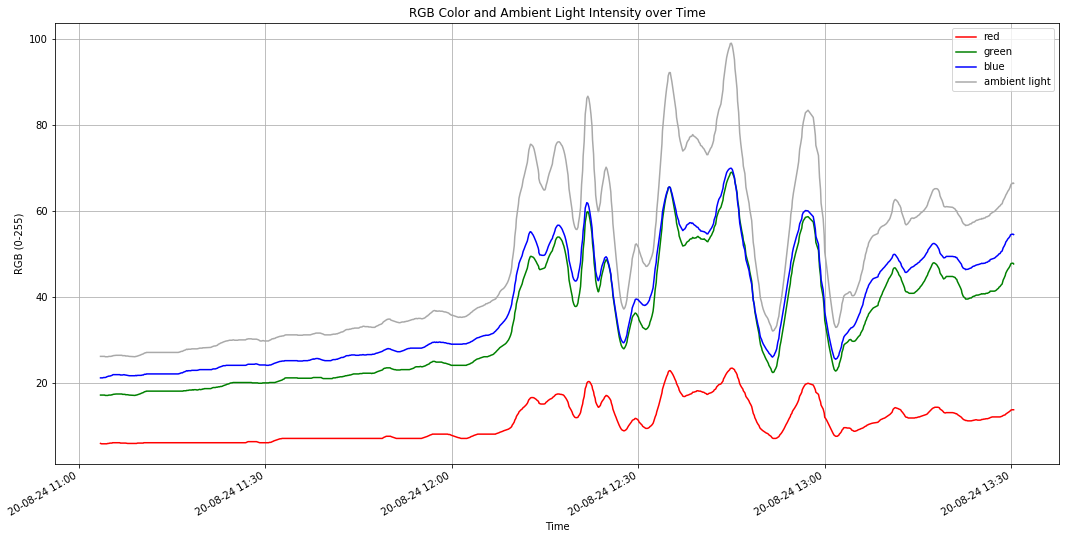

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(18, 9))

mean_red = df.red.rolling(window=12).mean()
mean_green = df.green.rolling(window=12).mean()
mean_blue = df.blue.rolling(window=12).mean()
mean_ambient = df.ambient.rolling(window=12).mean()

ax.plot(mean_red,
        label='red',
        color='red')
ax.plot(mean_green,
        label='green',
        color='green')
ax.plot(mean_blue,
        label='blue',
        color='blue')
ax.plot(mean_ambient,
        label='ambient light',
        color='darkgrey')

fig.autofmt_xdate()
ax.xaxis.set_major_formatter(myFmt)
ax.grid()
ax.margins(0.05)
ax.legend()
plt.title('RGB Color and Ambient Light Intensity over Time')
plt.ylabel('RGB (0-255)')
plt.xlabel('Time')
plt.show()

## Plotly vs. Matplotlib for Graphing
Graphs using Plotly Python Open Source Graphing Library

In [17]:
# strip timezone info so Plotly won't convert to UTC
df.index = df.index.tz_localize(None)

In [ ]:
fig = px.scatter(df,
                 x='temperature',
                 y='humidity',
                 color='device',
                 hover_name='device',
                 trendline='ols',
                 render_mode='svg',
                 hover_data={'device': False, 'temperature':':.2f', 'humidity':':.2f'})

fig.update_layout(title='Temperature vs. Humidity',
                  xaxis_title='Temperature (˚F)',
                  yaxis_title='Humidity (%)',
                  template='ggplot2')

fig.show()

<div style="height:60px;"><div style="height:7px;background-color:#20B3CD;width:100%;margin-top:20px;position:relative;"><img src="https://s3.amazonaws.com/iotanalytics-templates/Logo.png" style="height:50px;width:50px;margin-top:-20px;position:absolute;margin-left:42%;"></div></div>